# 특화 모델5(강서구)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.utils import resample
import shap

In [2]:
df = pd.read_csv("data/seoul_preprocessed.csv")
print(df.shape)

(44090, 31)


In [3]:
test_df = df.sample(frac=0.2, random_state=42)
train_df = df.drop(index=test_df.index)

In [4]:
# test를 제외한 데이터로 risk level 추출
df_nonzero = train_df[train_df['tow_count'] > 0]

# `tow_count` 값으로 정렬
df_nonzero = df_nonzero.sort_values(by='tow_count')

total_nonzero = len(df_nonzero)

mid_end = int(total_nonzero*1/2) # 절반

# 각 구간 끝값 (경계)
mid_end_value = df_nonzero.iloc[mid_end - 1]['tow_count']  # 가운데 구간 끝값

print(f"가운데 구간 끝값: {mid_end_value}\n")


train_df['risk_level'] = train_df['tow_count'].apply(
    lambda x: 0 if x == 0 else (1 if x <= mid_end_value else 2)
)

test_df['risk_level'] = test_df['tow_count'].apply(
    lambda x: 0 if x == 0 else (1 if x <= mid_end_value else 2)
)


# 결과 확인
print(train_df[['tow_count', 'risk_level']].tail())

가운데 구간 끝값: 2

       tow_count  risk_level
44085          0           0
44086          0           0
44087          0           0
44088          0           0
44089          0           0


In [5]:
# 지역 기반 분할
selected_gu = ["강서구"]
train_df = train_df[train_df["SIG_KOR_NM"].isin(selected_gu)]

In [6]:
features = train_df.columns[3:-2]
target = 'risk_level'
del train_df['tow_count']
del test_df['tow_count']

# 테스트 데이터 준비
train = train_df.iloc[:,3:]
X_test, y_test   = test_df[features], test_df[target]

In [7]:
exp_clf = setup(data = train, target = target, session_id=42)

,Description,Value
0,Session id,42
1,Target,risk_level
2,Target type,Multiclass
3,Original data shape,"(2406, 28)"
4,Transformed data shape,"(2406, 28)"
5,Transformed train set shape,"(1684, 28)"
6,Transformed test set shape,"(722, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


In [8]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8492,0.0000,0.8492,0.7436,0.7828,0.0207,0.0482,0.0280
dummy,Dummy Classifier,0.8486,0.5000,0.8486,0.7201,0.7791,0.0000,0.0000,0.0220
lr,Logistic Regression,0.8468,0.0000,0.8468,0.7961,0.8022,0.1536,0.2078,3.2530
rf,Random Forest Classifier,0.8462,0.8412,0.8462,0.7881,0.8003,0.1383,0.1923,0.3070
gbc,Gradient Boosting Classifier,0.8450,0.0000,0.8450,0.7923,0.8095,0.2043,0.2351,1.7180
et,Extra Trees Classifier,0.8426,0.8416,0.8426,0.7918,0.8067,0.1900,0.2292,0.2730
lightgbm,Light Gradient Boosting Machine,0.8379,0.8279,0.8379,0.7760,0.8006,0.1717,0.1963,11.3760
xgboost,Extreme Gradient Boosting,0.8373,0.8348,0.8373,0.7910,0.8081,0.2170,0.2392,0.4910
knn,K Neighbors Classifier,0.8349,0.7545,0.8349,0.7510,0.7856,0.0817,0.1036,1.5940
lda,Linear Discriminant Analysis,0.8337,0.0000,0.8337,0.7882,0.8043,0.2055,0.2267,0.0440


In [9]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8402,0.0000,0.8402,0.7896,0.8069,0.2157,0.2396
1,0.8521,0.0000,0.8521,0.7665,0.8017,0.1640,0.2323
2,0.8462,0.0000,0.8462,0.8037,0.8030,0.1501,0.1983
3,0.8107,0.0000,0.8107,0.7507,0.7761,0.0923,0.1007
4,0.8333,0.0000,0.8333,0.7685,0.7949,0.1235,0.1427
5,0.8631,0.0000,0.8631,0.8229,0.8291,0.2794,0.3228
6,0.8452,0.0000,0.8452,0.7557,0.7955,0.1208,0.1577
7,0.8571,0.0000,0.8571,0.8349,0.8368,0.3288,0.3458
8,0.8452,0.0000,0.8452,0.8015,0.8155,0.2232,0.2457


In [10]:
tuned_gbc = tune_model(gbc, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8284,0.0000,0.8284,0.8060,0.7893,0.1169,0.1369
1,0.8521,0.0000,0.8521,0.7672,0.7963,0.1180,0.2032
2,0.8639,0.0000,0.8639,0.8546,0.8166,0.2090,0.3198
3,0.8107,0.0000,0.8107,0.7488,0.7775,0.1102,0.1182
4,0.8452,0.0000,0.8452,0.7947,0.8099,0.1869,0.2159
5,0.8631,0.0000,0.8631,0.8011,0.8247,0.2610,0.3117
6,0.8631,0.0000,0.8631,0.8150,0.8247,0.2618,0.3122
7,0.8393,0.0000,0.8393,0.8033,0.8172,0.2461,0.2586
8,0.8274,0.0000,0.8274,0.7589,0.7885,0.0914,0.1056


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [11]:
final_model = finalize_model(tuned_gbc)
prediction = predict_model(final_model, data = X_test)

In [12]:
prediction

,isSchool,rental_count,return_count,apart,closest_hospital_dist,closest_convenience_dist,closest_culture_dist,age_20s,age_30s,age_40s,...,subway_avg_alight,area20,area30,area40,wp_area20,wp_area30,wp_area40,isCommercial,prediction_label,prediction_score
38207,0,0.000000,0.000000,0.000000,5.325478,4.627883,6.015660,8.276779,8.681676,8.432479,...,0.0,11.440591,11.843297,11.651719,3.795489,4.430817,4.471639,1,0,0.8450
34015,0,0.000000,0.000000,0.000000,5.086802,3.935616,5.987284,8.486584,8.766016,8.777035,...,0.0,12.414078,12.633709,12.621968,6.658653,6.378850,6.437352,1,0,0.8693
20315,0,3.559028,3.605673,0.000000,3.972599,3.193857,5.530240,7.868601,7.641568,7.488942,...,0.0,12.223945,12.231263,12.244367,3.481240,3.778491,3.921973,1,2,0.6171
32199,0,0.000000,0.000000,0.000000,4.434495,4.113351,6.348045,8.328084,8.386347,8.454794,...,0.0,12.411438,12.528260,12.538799,4.200954,4.943427,5.154736,1,0,0.9424
29840,0,0.000000,0.000000,7.850103,4.027646,4.496809,6.367069,7.717233,8.243472,8.305729,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.8995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41569,0,0.000000,0.000000,0.000000,4.783676,4.556271,6.712779,7.117584,7.240508,7.263411,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0.9058
22776,0,0.000000,0.000000,0.000000,3.764289,3.869840,5.768969,7.857319,7.983320,8.158035,...,0.0,9.822779,10.120211,10.381793,2.505526,2.602690,2.740840,1,0,0.8775
26942,0,0.000000,0.000000,7.126891,5.059654,4.032720,6.501971,8.422400,8.412317,8.552222,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0.8599
31596,0,4.559633,4.548770,5.891644,2.166850,2.288287,5.934356,8.995362,8.950693,8.692975,...,0.0,12.733198,12.722761,12.550138,7.326795,7.761639,7.744245,1,2,0.7427


In [13]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, prediction['prediction_label'], average ="weighted")
print(f"f1_score: {f1:.4f}")

f1_score: 0.7096


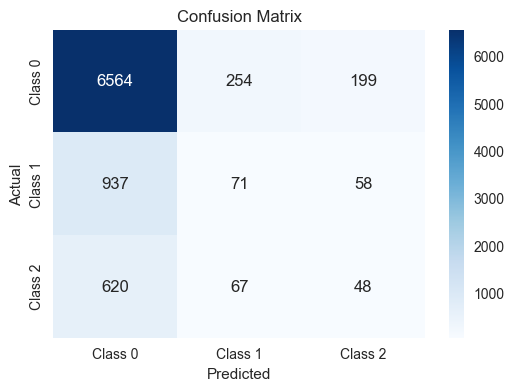

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 계산
cm = confusion_matrix(y_test, prediction['prediction_label'])

# 혼동 행렬 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

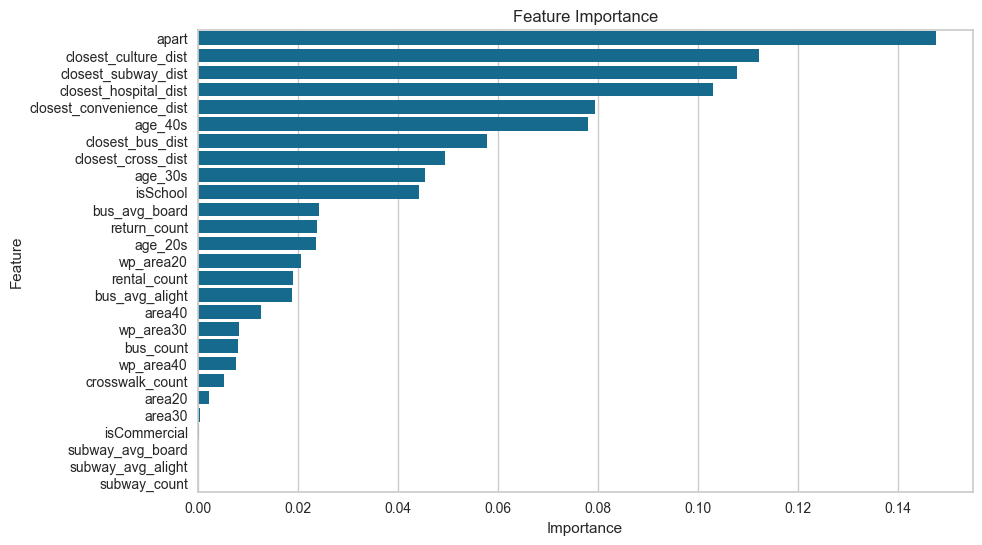

In [65]:
model_feature_importance = final_model.feature_importances_

# 중요도 값과 feature 이름을 함께 출력
features = get_config('X_train').columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': model_feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# 모델 저장
save_model(final_model, 'models/domain_specific_model_5')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['isSchool', 'rental_count',
                                              'return_count', 'apart',
                                              'closest_hospital_dist',
                                              'closest_convenience_dist',
                                              'closest_culture_dist', 'age_20s',
                                              'age_30s', 'age_40s',
                                              'crosswalk_count',
                                              'closest_cross_dist', 'bus_count',
                                              'closest_bus_dist', 'subway_count',
                                              'clos...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, lo